In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Peugeot.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_106,Seri_107,Seri_205,...,Model_GTI,Model_Quicksilver,Model_XR,Model_XS,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,475000,0.363636,-0.250000,0.000000,-0.456929,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,848000,0.636364,0.555556,0.000000,-0.958801,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,255000,-0.454545,-0.861111,-0.778846,-0.014981,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,187000,-1.181818,-0.333333,0.129808,0.224719,11.0,2.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,315000,-0.818182,0.222222,0.129808,0.134831,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14640\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45464.72208,2.160512e+09,46481.303038,30543.542734


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:21:29,941] A new study created in memory with name: no-name-8989fb96-5779-4e32-99bc-09fc7a5a18da
[I 2023-05-23 21:21:30,237] Trial 1 finished with value: 403047.645798613 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.00044011011472646803, 'max_depth': 6, 'min_child_weight': 208}. Best is trial 1 with value: 403047.645798613.
[I 2023-05-23 21:21:30,263] Trial 0 finished with value: 397915.4971146145 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.0018634671818943522, 'max_depth': 11, 'min_child_weight': 153}. Best is trial 0 with value: 397915.4971146145.
[I 2023-05-23 21:21:30,308] Trial 4 finished with value: 127024.62361645394 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.17908605254323795, 'max_depth': 6, 'min_child_weight': 237}. Best is trial 4 with value: 127024.62361645394.
[I 2023-05-23 21:21:30,310] Trial 2 finished with value: 393568.80455731583 and parameters: {'

[I 2023-05-23 21:21:32,252] Trial 31 finished with value: 57908.91199615209 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.48217547827348756, 'max_depth': 5, 'min_child_weight': 32}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:32,255] Trial 30 finished with value: 69770.28880098522 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.47083105282616555, 'max_depth': 4, 'min_child_weight': 63}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:32,258] Trial 32 finished with value: 161272.7168105993 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.09964107602365782, 'max_depth': 5, 'min_child_weight': 37}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:32,367] Trial 33 finished with value: 161274.48142437663 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.10036246077908055, 'max_depth': 5, 'min_child_weight': 

[I 2023-05-23 21:21:34,390] Trial 60 finished with value: 84269.85537160275 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.284473607252474, 'max_depth': 6, 'min_child_weight': 109}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:34,470] Trial 61 finished with value: 63522.18447542932 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.3591981618874832, 'max_depth': 6, 'min_child_weight': 47}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:34,545] Trial 64 finished with value: 58712.35215865156 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.49710240482229967, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 31 with value: 57908.91199615209.
[I 2023-05-23 21:21:34,583] Trial 63 finished with value: 58036.187060342665 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.3399185254655847, 'max_depth': 6, 'min_child_weight': 48}

[I 2023-05-23 21:21:37,222] Trial 92 finished with value: 64807.6715027664 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.351149954996686, 'max_depth': 10, 'min_child_weight': 75}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:37,225] Trial 89 finished with value: 65550.3872074468 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.35405745808383926, 'max_depth': 10, 'min_child_weight': 75}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:37,382] Trial 90 finished with value: 56500.12626164964 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.36659012239806665, 'max_depth': 10, 'min_child_weight': 37}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:37,818] Trial 93 finished with value: 111200.11415340846 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.1489844609782096, 'max_depth': 10, 'min_child_weight'

[I 2023-05-23 21:21:40,277] Trial 119 finished with value: 54876.95942763788 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.28050109210331575, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:40,301] Trial 121 finished with value: 53907.1065079118 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.2956532080517514, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:40,655] Trial 123 finished with value: 51619.05807611085 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.41200440478981504, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 78 with value: 51193.876605645535.
[I 2023-05-23 21:21:40,704] Trial 124 finished with value: 46254.93623048078 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.41463794266133797, 'max_depth': 13, 'min_child_w

[I 2023-05-23 21:21:42,906] Trial 150 finished with value: 53093.09148009043 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.42943174560183855, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:43,112] Trial 153 finished with value: 81601.83576232844 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.41984407278412866, 'max_depth': 15, 'min_child_weight': 151}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:43,162] Trial 154 finished with value: 51955.81688703548 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.42586731999430194, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:43,192] Trial 152 finished with value: 52303.11483472676 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.4288696349512486, 'max_depth': 15, 'min_child

[I 2023-05-23 21:21:45,627] Trial 179 finished with value: 51995.16810062299 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.27601609024967305, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:45,648] Trial 181 finished with value: 54739.18289964642 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.3550456573387533, 'max_depth': 13, 'min_child_weight': 15}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:45,734] Trial 182 finished with value: 58897.85410678584 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.2523270104597775, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:45,785] Trial 185 finished with value: 49417.06346850259 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.34696431631268543, 'max_depth': 13, 'min_child_we

[I 2023-05-23 21:21:48,339] Trial 211 finished with value: 50341.83048900058 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.47675998203074393, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:48,351] Trial 209 finished with value: 48870.05107627638 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.4907707454237481, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:48,424] Trial 213 finished with value: 52875.125281514054 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.49865482261239524, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:48,465] Trial 215 finished with value: 50176.36312556958 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.4074362961724582, 'max_depth': 15, 'min_child_we

[I 2023-05-23 21:21:51,204] Trial 245 finished with value: 230420.85573562284 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.058354782228236486, 'max_depth': 14, 'min_child_weight': 2}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:51,244] Trial 239 finished with value: 47131.39196253106 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.4096589912986566, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:51,270] Trial 242 finished with value: 46345.38111290238 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.40095981752143733, 'max_depth': 14, 'min_child_weight': 5}. Best is trial 124 with value: 46254.93623048078.
[I 2023-05-23 21:21:51,288] Trial 240 finished with value: 48695.5450900051 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4108084889084407, 'max_depth': 14, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 45236.5884
Best params:
	colsample_bytree: 0.7
	subsample: 0.5
	learning_rate: 0.4039522684661873
	max_depth: 14
	min_child_weight: 2


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [10,14],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.7],
               'subsample': [0.5],
               'min_child_weight': [2]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 14, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.5}
{'TestDeger': 48065.23937315787, 'MSE': 1982167091.238243, 'RMSE': 44521.535140179556, 'MAE': 32524.198254445608}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9334750889163792

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9225191370561319

In [17]:
marka_model = joblib.dump(grid_final_model, "Peugeot.pkl")

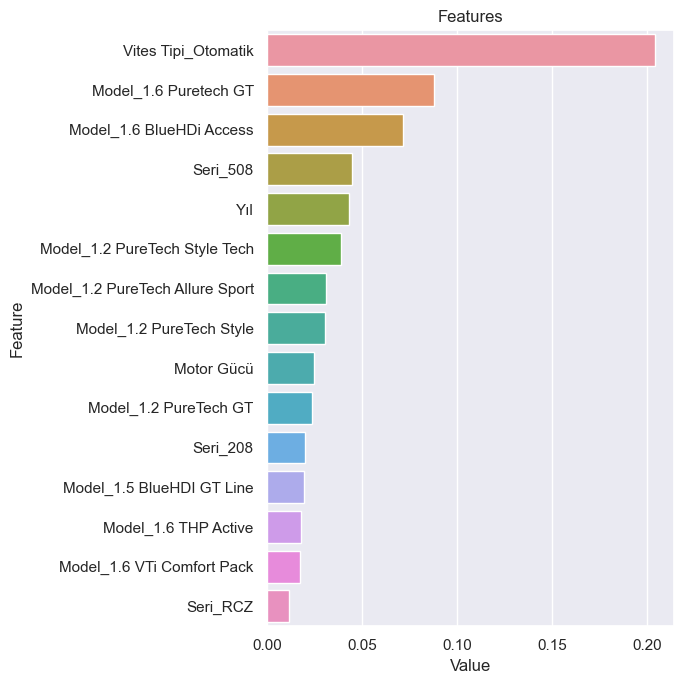

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)